Total Data Points: 880183
--- RUNNING RQ1 ANALYSIS ---


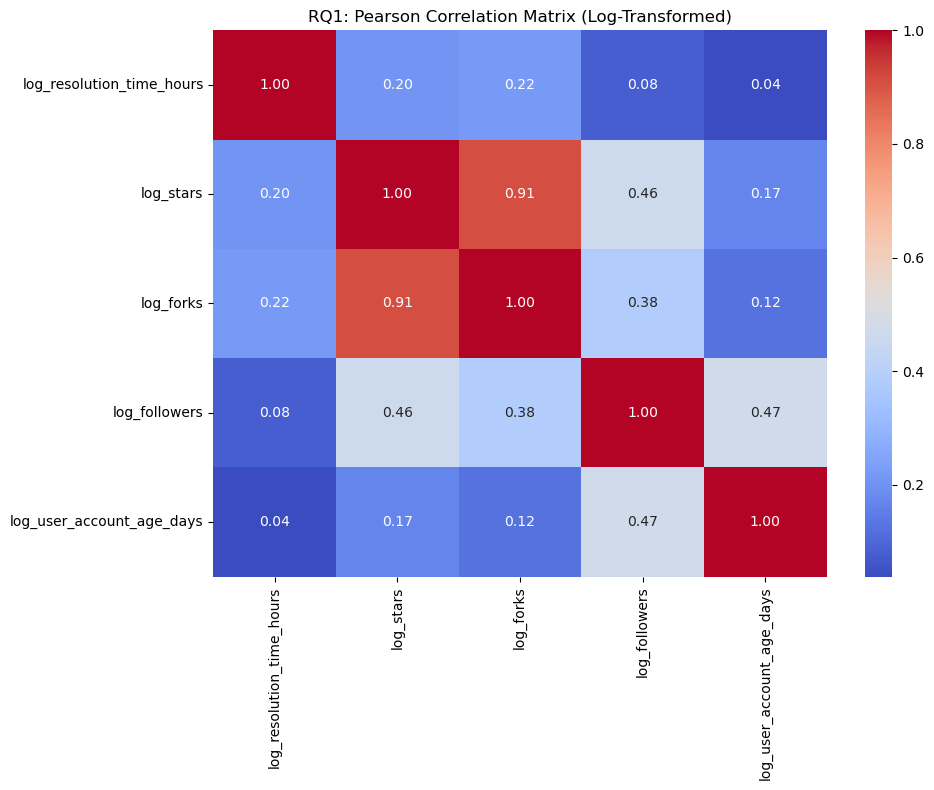

                                OLS Regression Results                               
Dep. Variable:     log_resolution_time_hours   R-squared:                       0.049
Model:                                   OLS   Adj. R-squared:                  0.049
Method:                        Least Squares   F-statistic:                 1.058e+04
Date:                       Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                               16:25:13   Log-Likelihood:            -1.1122e+06
No. Observations:                     817668   AIC:                         2.224e+06
Df Residuals:                         817663   BIC:                         2.225e+06
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

/var/folders/jz/ctf2jcsx7hd61fkfjnkhfld80000gn/T/ipykernel_87700/2561236424.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='popularity_tier', y='sentiment', data=df, showfliers=False, palette="Blues")


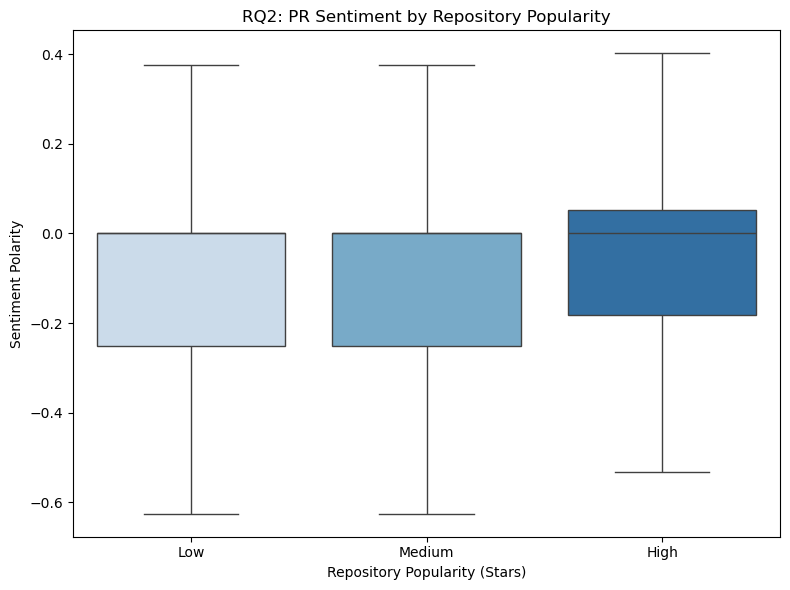

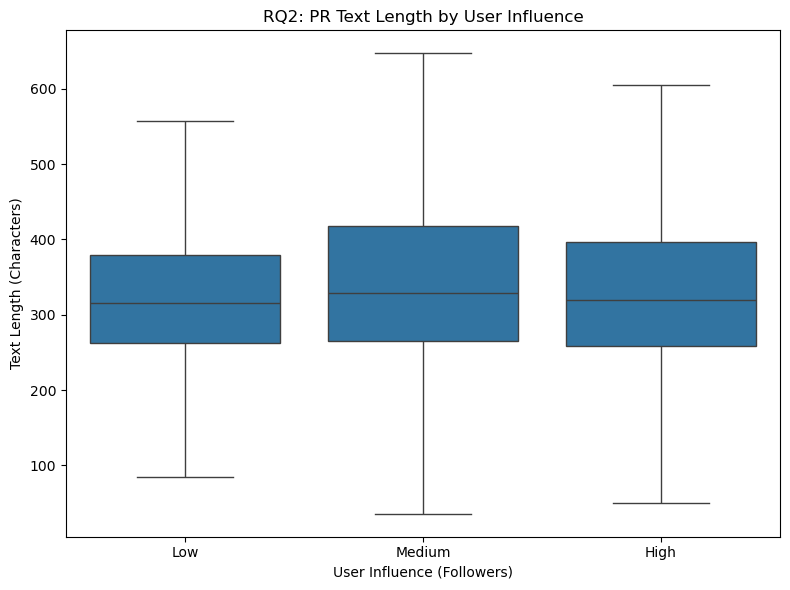


--- RUNNING RQ3 ANALYSIS: Specific Agent Benchmarking ---
          agent  total_prs  merged_prs  merge_rate
4  OpenAI_Codex     811969      711648    0.876447
1       Copilot        605         475    0.785124
0   Claude_Code       5113        3938    0.770194
2        Cursor      32752       23098    0.705239
3         Devin      29744       19170    0.644500


/var/folders/jz/ctf2jcsx7hd61fkfjnkhfld80000gn/T/ipykernel_87700/2561236424.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='agent', y='merge_rate', data=agent_stats, palette='viridis')


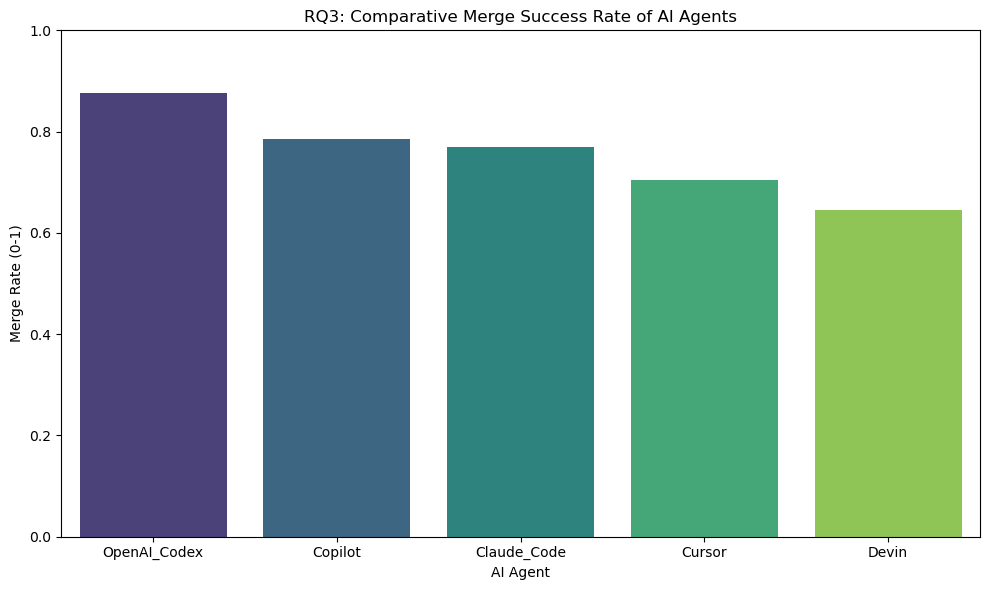

Analysis Complete. Images saved.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from textblob import TextBlob
import re

# --- 1. DATA LOADING & PREPROCESSING ---
all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

# Timestamp conversion
all_pr_df['created_at'] = pd.to_datetime(all_pr_df['created_at'])
all_pr_df['closed_at'] = pd.to_datetime(all_pr_df['closed_at'])
all_pr_df['merged_at'] = pd.to_datetime(all_pr_df['merged_at'])
all_user_df['created_at'] = pd.to_datetime(all_user_df['created_at'])

# Merging to create the FULL dataset
df = all_pr_df.merge(all_repo_df, left_on='repo_id', right_on='id', suffixes=('_pr', '_repo'))
df = df.merge(all_user_df, left_on='user_id', right_on='id', suffixes=('', '_user'))

# --- 2. FEATURE ENGINEERING ---

# Resolution Time (Hours)
df['resolution_time_hours'] = (df['closed_at'] - df['created_at']).dt.total_seconds() / 3600

# User Account Age (Days)
df['user_account_age_days'] = (df['created_at'] - df['created_at_user']).dt.days

# Log Transformations for skewed data (log1p handles 0s)
for col in ['stars', 'forks', 'followers', 'user_account_age_days', 'resolution_time_hours']:
    df[f'log_{col}'] = np.log1p(df[col])

# NLP Features
df['full_text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')
df['sentiment'] = df['full_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['text_length'] = df['full_text'].apply(len)

print(f"Total Data Points: {len(df)}")


# RQ1: REPOSITORY DYNAMICS
print("--- RUNNING RQ1 ANALYSIS ---")

rq1_data = df[df['state'] == 'closed'].dropna(subset=[
    'log_resolution_time_hours', 'log_stars', 'log_forks', 'log_followers', 'log_user_account_age_days'
])

# 1.1 Correlation Matrix
corr_cols = ['log_resolution_time_hours', 'log_stars', 'log_forks', 'log_followers', 'log_user_account_age_days']
plt.figure(figsize=(10, 8))
sns.heatmap(rq1_data[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("RQ1: Pearson Correlation Matrix (Log-Transformed)")
plt.tight_layout()
plt.savefig('RQ1-1.png')
plt.show()

# 1.2 OLS Regression
X = rq1_data[['log_stars', 'log_forks', 'log_followers', 'log_user_account_age_days']]
X = sm.add_constant(X)
y = rq1_data['log_resolution_time_hours']

model = sm.OLS(y, X).fit()
print(model.summary())


# RQ2: TEXT CHARACTERISTICS
print("\n--- RUNNING RQ2 ANALYSIS ---")

# Using rank(method='first') ensures we always get 3 distinct bins even if there are thousands of zeros.
df['popularity_tier'] = pd.qcut(df['stars'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High'])
df['influence_tier'] = pd.qcut(df['followers'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High'])

# 2.1 Sentiment vs Popularity
plt.figure(figsize=(8, 6))
sns.boxplot(x='popularity_tier', y='sentiment', data=df, showfliers=False, palette="Blues")
plt.title("RQ2: PR Sentiment by Repository Popularity")
plt.xlabel("Repository Popularity (Stars)")
plt.ylabel("Sentiment Polarity")
plt.tight_layout()
plt.savefig('RQ2_1.png')
plt.show()

# 2.2 Text Length vs Influence
plt.figure(figsize=(8, 6))
sns.boxplot(x='influence_tier', y='text_length', data=df, showfliers=False)
plt.title("RQ2: PR Text Length by User Influence")
plt.xlabel("User Influence (Followers)")
plt.ylabel("Text Length (Characters)")
plt.tight_layout()
plt.savefig('RQ2_2.png')
plt.show()


# RQ3: AI AGENT BENCHMARKING
print("\n--- RUNNING RQ3 ANALYSIS: Specific Agent Benchmarking ---")

target_agents = ['Claude_Code', 'Copilot', 'OpenAI_Codex', 'Cursor', 'Devin']

if 'agent' in df.columns:
    # Filter using full df
    rq3_data = df[df['agent'].isin(target_agents)].copy()
    
    # Calculate stats
    agent_stats = rq3_data.groupby('agent').agg(
        total_prs=('id', 'count'),
        merged_prs=('merged_at', 'count')
    ).reset_index()
    
    # Calculate Merge Rate
    agent_stats['merge_rate'] = agent_stats['merged_prs'] / agent_stats['total_prs']
    
    # Sort for chart
    agent_stats = agent_stats.sort_values('merge_rate', ascending=False)
    
    print(agent_stats)

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x='agent', y='merge_rate', data=agent_stats, palette='viridis')
    plt.title("RQ3: Comparative Merge Success Rate of AI Agents")
    plt.ylabel("Merge Rate (0-1)")
    plt.xlabel("AI Agent")
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig('RQ3_2.png')
    plt.show()
else:
    print("Column 'agent' not found. Please verify the column name in your dataframe.")

print("Analysis Complete. Images saved.")